<a href="https://colab.research.google.com/github/dmw1998/Case_Study_Log/blob/main/Full_model_One_PCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install casadi
!pip install chaospy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.7/369.7 kB 5.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.4/254.4 kB 15.1 MB/s eta 0:00:00
  Created wheel for numpoly: filename=numpoly-1.3.6-cp311-cp311-linux_x86_64.whl size=1070488 sha256=d8f2a1ba65b2bdc8e4b1dfb59360f3d514d86ce608bcafca9a4e6ab127d24d99
  Stored in directory: /root/.cache/pip/wheels/4f/f2/9a/4a5e38490fba7e23bdd2d56ec2e62e44c400179ad513427956
Successfully built numpoly


In [2]:
import casadi as ca
import chaospy as cp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [3]:
dist = cp.Normal(1.0, 0.25)
poly_basis = cp.expansion.stieltjes(5, dist, retall=False)
nodes, weights = cp.generate_quadrature(5, dist, rule='gaussian')

print(nodes)
print(weights)

[[0.16893564 0.52770603 0.84582335 1.15417665 1.47229397 1.83106436]]
[0.00255578 0.08861575 0.40882847 0.40882847 0.08861575 0.00255578]


In [23]:
def solve_ocp_pce(pce_order=5, k_mean=1.0, k_std=0.25):
    # Time and discretization
    tf = 40        # final time [sec]
    N = 80         # number of control intervals
    dt = tf / N    # time step

    # Aircraft physical constants
    m = 4662                # mass [lb sec^2 / ft]
    g = 32.172              # gravity [ft/sec^2]
    delta = 0.03491         # thrust inclination angle [rad]

    # Thrust model coefficients: T = A0 + A1*V + A2*V^2
    A0 = 0.4456e5           # [lb]
    A1 = -0.2398e2          # [lb sec / ft]
    A2 = 0.1442e-1          # [lb sec^2 / ft^2]

    # Aerodynamic model
    rho = 0.2203e-2         # air density [lb sec^2 / ft^4]
    S = 0.1560e4            # reference surface area [ft^2]

    # Wind model 3 beta (smoothing) parameters
    beta0 = 0.4             # initial beta value (approximate)
    beta_dot0 = 0.2         # initial beta rate
    sigma = 3               # time to reach beta = 1 [sec]

    # C_D(alpha) = B0 + B1 * alpha + B2 * alpha**2, D = 0.5 * C_D(α) * ρ * S * V²
    B0 = 0.1552
    B1 = 0.12369            # [1/rad]
    B2 = 2.4203             # [1/rad^2]

    # Lift coefficient: C_L = C0 + C1 * alpha (+ C2 * alpha**2)
    C0 = 0.7125             # baseline lift coefficient
    C1 = 6.0877             # AOA lift slope [1/rad]

    # Lift/drag model optional extensions (if needed)
    C2 = -9.0277            # [rad^-2] — e.g., for moment or drag extension

    # Angle of attack & control constraints
    umax = 0.05236          # max control input (rate of change of alpha) [rad/sec]
    alphamax = 0.3          # max angle of attack [rad]
    alpha_star = 0.20944    # changing pt of AoA

    # Wind model x parameters (piecewise smooth wind)
    a = 6e-8                 # x transition midpoint [ft]
    b = -4e-11               # second transition point [ft]

    # Wind model h parameters (polynomial form)
    c = -np.log(25/30.6)*1e-12      # transition smoothing width [ft]
    d = -8.02881e-8         # polynomial coeff [sec^-1 ft^-2]
    e = 6.28083e-11         # polynomial coeff [sec^-1 ft^-3]

    # Cost function / target altitude
    hR = 1000               # reference altitude [ft]
    h_star = 1000           # used in some wind models

    # Auxiliary
    eps = 1e-6              # to avoid division by zero in V

    # Scaling factors (used if normalizing states)
    xscale = 10000          # [ft]
    hscale = 1000           # [ft]
    Vscale = 240            # [ft/sec]
    gammascale = 0.1        # [rad]
    alphascale = 0.3        # [rad]
    uscale = 0.05           # [rad/sec]

    # PCE parameters
    dist = cp.Normal(k_mean, k_std)
    poly_basis = cp.expansion.stieltjes(pce_order, dist, retall=False)
    nodes, weights = cp.generate_quadrature(pce_order, dist, rule='gaussian')
    nodes = nodes.flatten()
    M = len(nodes)    # M = pce_order + 1

    Psi_mat = np.zeros((M, M))
    for i in range(M):
        Psi_mat[:, i] = poly_basis[i](nodes)

    Psi_dm = ca.DM(Psi_mat)
    weights_dm = ca.DM(weights).T

    # Opti instance and scaled variables
    opti = ca.Opti()
    x_s = opti.variable(M, N+1)
    h_s = opti.variable(M, N+1)
    V_s = opti.variable(M, N+1)
    gamma_s = opti.variable(M, N+1)
    alpha_s = opti.variable(M, N+1)
    X_pce = opti.variable(5*(pce_order+1), N+1)
    u_s = opti.variable(N)

    # Unscaled variables for dynamics
    x = x_s * xscale
    h = h_s * hscale
    V = V_s * Vscale
    gamma = gamma_s * gammascale
    alpha = alpha_s * alphascale
    u = u_s * uscale

    def Smooth(x_, x0, x1):
        t = (x_ - x0) / (x1 - x0 + eps)
        return ca.if_else(x_ < x0, 0,
               ca.if_else(x_ > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

    def A_piecewise(x_):
        A1 = -50 + a * x_**3 + b * x_**4
        A2 = 0.025 * (x_ - 2300)
        A3 = 50 - a * (4600 - x_)**3 - b * (4600 - x_)**4
        A4 = 50
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*A1 + s1*A2
        B23 = (1 - s2)*A2 + s2*A3
        B34 = (1 - s3)*A3 + s3*A4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, A4)))

    def B_piecewise(x_):
        B1 = d * x_**3 + e * x_**4
        B2 = -51 * ca.exp(ca.fmin(-c * (x_ - 2300)**4, 30))
        B3 = d * (4600 - x_)**3 + e * (4600 - x_)**4
        B4 = 0
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*B1 + s1*B2
        B23 = (1 - s2)*B2 + s2*B3
        B34 = (1 - s3)*B3 + s3*B4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, B4)))

    def wind_x(x_, k_):
        return k_ * A_piecewise(x_)

    def wind_h(x_, h_, k_):
        h_safe = ca.fmax(h_, 10.0)
        return k_ * h_safe / h_star * B_piecewise(x_)

    def C_L(alpha_):
        return ca.if_else(alpha_ > alpha_star, C0 + C1 * alpha_,
                          C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2)
    def beta(t_):
        return ca.if_else(t_ < sigma, beta0 + beta_dot0 * t_, 1.0)

    # Symbolic derivatives
    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")
    k_sym = ca.MX.sym("k")
    Wx_expr = wind_x(x_sym, k_sym)
    Wh_expr = wind_h(x_sym, h_sym, k_sym)
    dWx_dx_fun = ca.Function("dWx_dx", [x_sym, k_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym, k_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym, k_sym], [ca.gradient(Wh_expr, h_sym)])

    def aircraft_ode(X, u_, t_, k_val):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)

        T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
        D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
        L = 0.5 * rho * S * C_L(alpha_) * V_**2

        Wx = wind_x(x_, k_val)
        Wh = wind_h(x_, h_, k_val)
        V_safe = ca.fmax(V_, 1e-3)

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        dWx_dx_val = dWx_dx_fun(x_, k_val)[0]
        dWh_dx_val = dWh_dx_fun(x_, h_, k_val)[0]
        dWh_dh_val = dWh_dh_fun(x_, h_, k_val)[0]

        Wx_dot = dWx_dx_val * x_dot
        Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_) + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
        alpha_dot = u_

        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    def rk4_step(f, xk, uk, tk, dt, k_val):
        k1 = f(xk, uk, tk, k_val)
        k2 = f(xk + dt/2 * k1, uk, tk + dt/2, k_val)
        k3 = f(xk + dt/2 * k2, uk, tk + dt/2, k_val)
        k4 = f(xk + dt * k3, uk, tk + dt, k_val)
        return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    # # Integration using RK4
    # X_sym = ca.MX.sym("X", 5)
    # u_sym = ca.MX.sym("u")

    J = 0

    # Initial conditions
    opti.subject_to(x_s[:, 0] == 0)
    opti.subject_to(h_s[:, 0] == 600 / hscale)
    opti.subject_to(V_s[:, 0] == 239.7 / Vscale)
    opti.subject_to(gamma_s[:, 0] == -0.03925 / gammascale)
    opti.subject_to(alpha_s[:, 0] == 0.1283 / alphascale)
    opti.subject_to(ca.vec(V_s) >= 1e-2 / Vscale)
    # opti.subject_to(gamma_s[:, -1] == -0.05236 / gammascale)

    # for i in range(N):
    #     h_physical = h_s[:, i] * hscale
    #     h_mean = ca.mtimes(weights_dm, h_physical)
    #     deviation = hR - h_mean
    #     scaled_deviation = deviation / hscale
    #     J += dt * scaled_deviation**6

    #     for j, k_val in enumerate(nodes):
    #         tk = i * dt     # New line
    #         Xk = ca.vertcat(x[j, i], h[j, i], V[j, i], gamma[j, i], alpha[j, i])
    #         Uk = u[i]
    #         Xk_end = rk4_step(aircraft_ode, Xk, Uk, tk, dt, k_val)
    #         X_next = ca.vertcat(x[j, i+1], h[j, i+1], V[j, i+1], gamma[j, i+1], alpha[j, i+1])
    #         opti.subject_to(X_next == Xk_end)

    #     opti.subject_to(opti.bounded(-1, u_s[i], 1))
    #     alpha_i = alpha_s[:, i] * alphascale
    #     alpha_pce_coeffs = ca.mtimes(weights_dm * alpha_i.T, Psi_dm)
    #     alpha_high_coeffs = alpha_pce_coeffs[1:]
    #     alpha_mean = ca.mtimes(weights_dm, alpha_i)
    #     std_term = ca.sqrt(ca.sumsqr(alpha_high_coeffs))

    #     opti.subject_to(alpha_mean + 3 * std_term <= alphamax)
    #     opti.subject_to(alpha_mean - 3 * std_term >= -alphamax)

    for j, k_val in enumerate(nodes):

        for i in range(N):
            h_physical = h_s[:, i] * hscale
            h_mean = ca.mtimes(weights_dm, h_physical)

            h_pce_coeffs = ca.mtimes(weights_dm * h_physical.T, Psi_dm)
            h_high_coeffs = h_pce_coeffs[1:]
            h_std_term = ca.sqrt(ca.sumsqr(h_high_coeffs))

            deviation = hR - h_mean + h_std_term * 12
            scaled_deviation = deviation / hscale
            J += dt * scaled_deviation**6

            tk = i * dt     # New line
            Xk = ca.vertcat(x[j, i], h[j, i], V[j, i], gamma[j, i], alpha[j, i])
            Uk = u[i]
            Xk_end = rk4_step(aircraft_ode, Xk, Uk, tk, dt, k_val)
            X_next = ca.vertcat(x[j, i+1], h[j, i+1], V[j, i+1], gamma[j, i+1], alpha[j, i+1])
            opti.subject_to(X_next == Xk_end)

            opti.subject_to(opti.bounded(-1, u_s[i], 1))

        alpha_i = alpha_s[:, i] * alphascale
        alpha_pce_coeffs = ca.mtimes(weights_dm * alpha_i.T, Psi_dm)
        alpha_high_coeffs = alpha_pce_coeffs[1:]
        alpha_mean = ca.mtimes(weights_dm, alpha_i)
        std_term = ca.sqrt(ca.sumsqr(alpha_high_coeffs))

        opti.subject_to(alpha_mean + 3 * std_term <= alphamax)
        opti.subject_to(alpha_mean - 3 * std_term >= -alphamax)


    # # Cost function
    # J = dt * ca.sumsqr((h_s - (hR / hscale))**3)
    opti.minimize(J)

    # Initial guess
    for j in range(M):
        opti.set_initial(x_s[j, :], np.linspace(0, 1, N+1))
        opti.set_initial(h_s[j, :], 0.6)  # 600 ft / 1000
        opti.set_initial(V_s[j, :], 239.7 / Vscale)
        opti.set_initial(gamma_s[j, :], -0.01 / gammascale)
        opti.set_initial(alpha_s[j, :], 0.02 / alphascale)
    opti.set_initial(u_s, 0)

    # Solver
    opts = {
        "expand": True,
        "ipopt": {
            # "max_iter": 3000,
            "max_cpu_time": 120,
            "tol": 1e-6,
            "print_level": 5,
            "linear_solver": "mumps",
            "hessian_approximation": "limited-memory",
            # "bound_push": 1e-8,
            # "bound_frac": 1e-8
        }
    }
    opti.solver("ipopt", opts)

    try:
        sol = opti.solve()
    except RuntimeError as e:
        opti.debug.show_infeasibilities()
        print(e)
        return {
            "x": opti.debug.value(x),
            "h": opti.debug.value(h),
            "V": opti.debug.value(V),
            "gamma": opti.debug.value(gamma),
            "alpha": opti.debug.value(alpha),
            "u": opti.debug.value(u),
            "J": opti.debug.value(J),
            "status": "failed"
        }

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
        "status": "success"
    }

In [24]:
res = solve_ocp_pce(pce_order=5, k_mean=1.0, k_std=0.25)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    14910
Number of nonzeros in inequality constraint Jacobian.:     1038
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2510
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2430
Total number of inequality constraints...............:      978
        inequality constraints with only lower bounds:      492
   inequality constraints with lower and upper bounds:      480
        inequality constraints with only upper bounds:        6

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.8304000e-01 5.09e+01 2.56e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

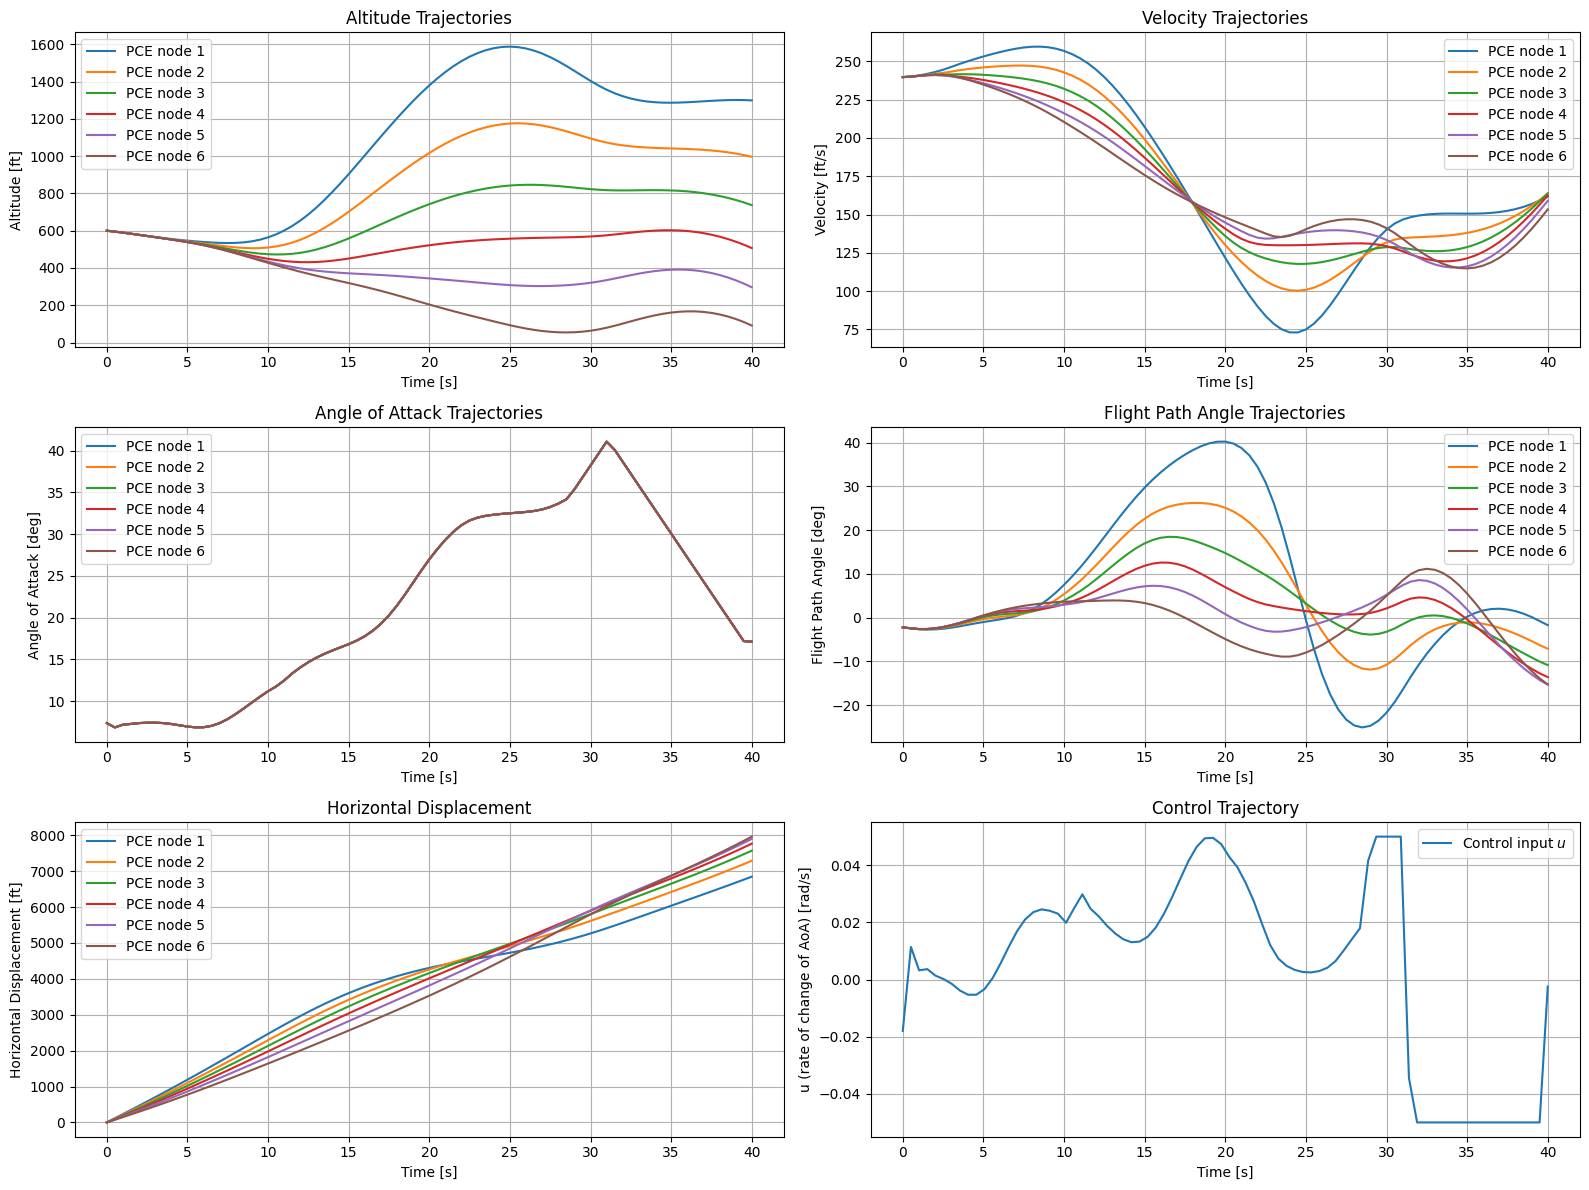

In [19]:
def plot_ocp_pce_result(res, tf=40, N=80, title_prefix=''):
    # 解包
    x = res['x']   # (M, N+1)
    h = res['h']
    V = res['V']
    gamma = res['gamma']
    alpha = res['alpha']
    u = res['u']   # (N,)
    M = x.shape[0]
    t_grid = np.linspace(0, tf, N+1)
    t_ctrl = np.linspace(0, tf, N)

    plt.figure(figsize=(16, 12))

    # 高度轨迹
    plt.subplot(3,2,1)
    for j in range(M):
        plt.plot(t_grid, h[j], label=f'PCE node {j+1}')
    plt.xlabel('Time [s]')
    plt.ylabel('Altitude [ft]')
    plt.title(f'{title_prefix}Altitude Trajectories')
    plt.grid(True)
    plt.legend()

    # 速度轨迹
    plt.subplot(3,2,2)
    for j in range(M):
        plt.plot(t_grid, V[j], label=f'PCE node {j+1}')
    plt.xlabel('Time [s]')
    plt.ylabel('Velocity [ft/s]')
    plt.title(f'{title_prefix}Velocity Trajectories')
    plt.grid(True)
    plt.legend()

    # 迎角轨迹
    plt.subplot(3,2,3)
    for j in range(M):
        plt.plot(t_grid, alpha[j]*180/np.pi, label=f'PCE node {j+1}')
    plt.xlabel('Time [s]')
    plt.ylabel('Angle of Attack [deg]')
    plt.title(f'{title_prefix}Angle of Attack Trajectories')
    plt.grid(True)
    plt.legend()

    # 航迹角轨迹
    plt.subplot(3,2,4)
    for j in range(M):
        plt.plot(t_grid, gamma[j]*180/np.pi, label=f'PCE node {j+1}')
    plt.xlabel('Time [s]')
    plt.ylabel('Flight Path Angle [deg]')
    plt.title(f'{title_prefix}Flight Path Angle Trajectories')
    plt.grid(True)
    plt.legend()

    # 水平位移
    plt.subplot(3,2,5)
    for j in range(M):
        plt.plot(t_grid, x[j], label=f'PCE node {j+1}')
    plt.xlabel('Time [s]')
    plt.ylabel('Horizontal Displacement [ft]')
    plt.title(f'{title_prefix}Horizontal Displacement')
    plt.grid(True)
    plt.legend()

    # 控制量
    plt.subplot(3,2,6)
    plt.plot(t_ctrl, u, label='Control input $u$')
    plt.xlabel('Time [s]')
    plt.ylabel('u (rate of change of AoA) [rad/s]')
    plt.title(f'{title_prefix}Control Trajectory')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_ocp_pce_result(res)

54.2749806641468


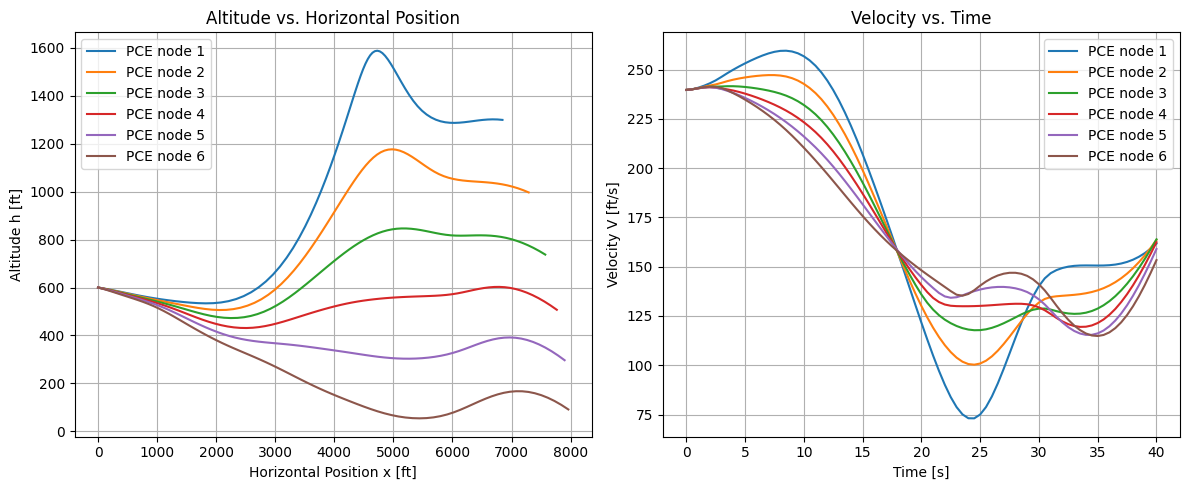

In [20]:
def plot_pce_trajectories(res, tf=40, N=80):
    x = res['x']    # shape: (M, N+1)
    h = res['h']
    V = res['V']
    M = x.shape[0]
    t_grid = np.linspace(0, tf, N+1)

    print(min(h.flatten()))

    plt.figure(figsize=(12,5))

    # h-x plot
    plt.subplot(1,2,1)
    for j in range(M):
        plt.plot(x[j], h[j], label=f'PCE node {j+1}')
    plt.xlabel('Horizontal Position x [ft]')
    plt.ylabel('Altitude h [ft]')
    plt.title('Altitude vs. Horizontal Position')
    plt.grid(True)
    plt.legend()

    # V-t plot
    plt.subplot(1,2,2)
    for j in range(M):
        plt.plot(t_grid, V[j], label=f'PCE node {j+1}')
    plt.xlabel('Time [s]')
    plt.ylabel('Velocity V [ft/s]')
    plt.title('Velocity vs. Time')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_pce_trajectories(res)


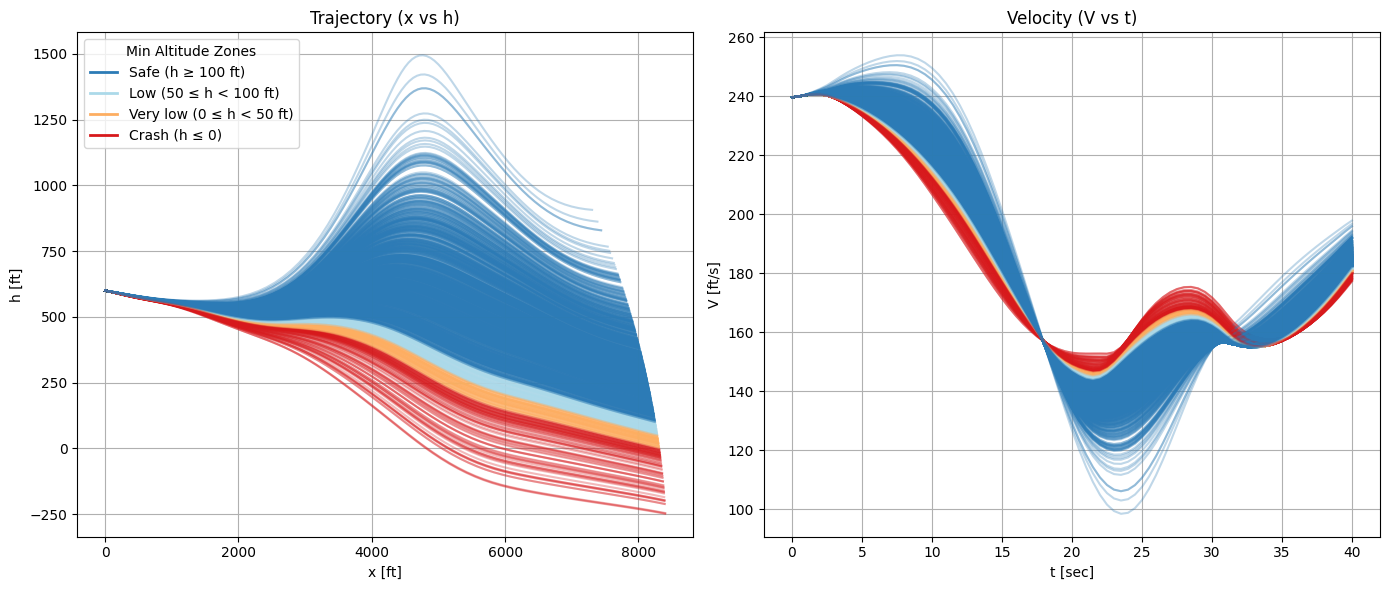

P(Under 100) = 0.1950
P(Under 50) = 0.1300
P(Under 0) = 0.0770


In [22]:
colors = {
    "safe": "#2c7bb6",      # Dark Blue
    "low": "#abd9e9",       # Light Blue
    "very_low": "#fdae61",  # Orange
    "crash": "#d7191c"      # Red
}

u_opt = res["u"]

# Physical constants
m = 4662
g = 32.172
delta = 0.03491
A0 = 0.4456e5
A1 = -0.2398e2
A2 = 0.1442e-1
rho = 0.2203e-2
S = 0.1560e4
beta0 = 0.4
beta_dot0 = 0.2
sigma = 3
B0 = 0.1552
B1 = 0.12369
B2 = 2.4203
C0 = 0.7125
C1 = 6.0877
C2 = -9.0277
alpha_star = 0.20944
a = 6e-8
b = -4e-11
c = -np.log(25/30.6)*1e-12
d = -8.02881e-8
e = 6.28083e-11
h_star = 1000
eps = 1e-6

# Wind model functions
def Smooth(x_, x0, x1):
    t = (x_ - x0) / (x1 - x0 + eps)
    return ca.if_else(x_ < x0, 0,
           ca.if_else(x_ > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

def A_piecewise(x_):
    A1v = -50 + a * x_**3 + b * x_**4
    A2 = 0.025 * (x_ - 2300)
    A3 = 50 - a * (4600 - x_)**3 - b * (4600 - x_)**4
    A4 = 50
    s1 = Smooth(x_, 480, 520)
    s2 = Smooth(x_, 4080, 4120)
    s3 = Smooth(x_, 4580, 4620)
    B12 = (1 - s1)*A1v + s1*A2
    B23 = (1 - s2)*A2 + s2*A3
    B34 = (1 - s3)*A3 + s3*A4
    return ca.if_else(x_ <= 500, B12,
           ca.if_else(x_ <= 4100, B23,
           ca.if_else(x_ <= 4600, B34, A4)))

def B_piecewise(x_):
    B1v = d * x_**3 + e * x_**4
    B2 = -51 * ca.exp(ca.fmin(-c * (x_ - 2300)**4, 30))
    B3 = d * (4600 - x_)**3 + e * (4600 - x_)**4
    B4 = 0
    s1 = Smooth(x_, 480, 520)
    s2 = Smooth(x_, 4080, 4120)
    s3 = Smooth(x_, 4580, 4620)
    B12 = (1 - s1)*B1v + s1*B2
    B23 = (1 - s2)*B2 + s2*B3
    B34 = (1 - s3)*B3 + s3*B4
    return ca.if_else(x_ <= 500, B12,
           ca.if_else(x_ <= 4100, B23,
           ca.if_else(x_ <= 4600, B34, B4)))

def wind_x(x_, k_):
    return k_ * A_piecewise(x_)

def wind_h(x_, h_, k_):
    h_safe = ca.fmax(h_, 10.0)
    return k_ * h_safe / h_star * B_piecewise(x_)

def prepare_numpy_wind_functions(k_value):
    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")
    Wx_expr = wind_x(x_sym, k_value)
    Wh_expr = wind_h(x_sym, h_sym, k_value)
    dWx_dx_fun = ca.Function("dWx_dx", [x_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym], [ca.gradient(Wh_expr, h_sym)])
    Wx_fun = ca.Function("Wx_fun", [x_sym], [Wx_expr])
    Wh_fun = ca.Function("Wh_fun", [x_sym, h_sym], [Wh_expr])
    return {
        "Wx": Wx_fun,
        "Wh": Wh_fun,
        "dWx_dx": dWx_dx_fun,
        "dWh_dx": dWh_dx_fun,
        "dWh_dh": dWh_dh_fun
    }

def get_numpy_aircraft_ode(k_value):
    wind_funcs = prepare_numpy_wind_functions(k_value)
    def aircraft_ode_np(X, u, t):
        x_, h_, V_, gamma_, alpha_ = X
        T = (beta0 + beta_dot0 * t if t < sigma else 1.0) * (A0 + A1 * V_ + A2 * V_**2)
        D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
        CL = C0 + C1 * alpha_ if alpha_ <= alpha_star else C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2
        L = 0.5 * rho * S * CL * V_**2
        Wx = float(wind_funcs["Wx"](x_))
        Wh = float(wind_funcs["Wh"](x_, h_))
        dWx_dx = float(wind_funcs["dWx_dx"](x_))
        dWh_dx = float(wind_funcs["dWh_dx"](x_, h_))
        dWh_dh = float(wind_funcs["dWh_dh"](x_, h_))
        V_safe = max(V_, 1e-3)
        x_dot = V_ * np.cos(gamma_) + Wx
        h_dot = V_ * np.sin(gamma_) + Wh
        Wx_dot = dWx_dx * x_dot
        Wh_dot = dWh_dx * x_dot + dWh_dh * h_dot
        V_dot = T / m * np.cos(alpha_ + delta) - D / m - g * np.sin(gamma_) - (Wx_dot * np.cos(gamma_) + Wh_dot * np.sin(gamma_))
        gamma_dot = T / (m * V_safe) * np.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * np.cos(gamma_) + (1 / V_safe) * (Wx_dot * np.sin(gamma_) - Wh_dot * np.cos(gamma_))
        alpha_dot = u
        return np.array([x_dot, h_dot, V_dot, gamma_dot, alpha_dot])
    return aircraft_ode_np

def rk4_step_np(f, xk, uk, tk, dt):
    k1 = f(xk, uk, tk)
    k2 = f(xk + dt/2 * k1, uk, tk + dt/2)
    k3 = f(xk + dt/2 * k2, uk, tk + dt/2)
    k4 = f(xk + dt * k3, uk, tk + dt)
    return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

# Set simulation parameters
np.random.seed(10)
k_values = np.random.normal(1.0, 0.25, 1000)
tf = 40
N = 80
dt = 40 / 80
x0 = 0
h0 = 600
V0 = 239.7
gamma0 = -0.03925
alpha0 = 0.1283

under_0, under_50, under_100 = 0, 0, 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for k in k_values:
    ode = get_numpy_aircraft_ode(k)
    X = np.array([x0, h0, V0, gamma0, alpha0])
    traj = {"x": [], "h": [], "V": [], "t": []}

    for i, u in enumerate(u_opt):
        t = i * dt
        traj["x"].append(X[0])
        traj["h"].append(X[1])
        traj["V"].append(X[2])
        traj["t"].append(t)
        X = rk4_step_np(ode, X, u, t, dt)

    traj["x"].append(X[0])
    traj["h"].append(X[1])
    traj["V"].append(X[2])
    traj["t"].append(t + dt)

    if min(traj["h"]) < 1e-6:
        under_0 += 1
        ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["crash"])
        ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["crash"])
    elif min(traj["h"]) < 50:
        under_50 += 1
        ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["very_low"])
        ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["very_low"])
    elif min(traj["h"]) < 100:
        under_100 += 1
        ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["low"])
        ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["low"])
    else:
        ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["safe"])
        ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["safe"])

ax1.set_xlabel("x [ft]")
ax1.set_ylabel("h [ft]")
ax1.set_title("Trajectory (x vs h)")
ax1.grid(True)
legend_elements = [
    Line2D([0], [0], color=colors["safe"],      lw=2, label='Safe (h ≥ 100 ft)'),
    Line2D([0], [0], color=colors["low"],       lw=2, label='Low (50 ≤ h < 100 ft)'),
    Line2D([0], [0], color=colors["very_low"],  lw=2, label='Very low (0 ≤ h < 50 ft)'),
    Line2D([0], [0], color=colors["crash"],     lw=2, label='Crash (h ≤ 0)')
]
ax1.legend(handles=legend_elements, loc='upper left', title="Min Altitude Zones")

ax2.set_xlabel("t [sec]")
ax2.set_ylabel("V [ft/s]")
ax2.set_title("Velocity (V vs t)")
ax2.grid(True)
# ax2.legend()

plt.tight_layout()
plt.show()

print(f"P(Under 100) = {(under_100+under_50+under_0)/len(k_values):.4f}")
print(f"P(Under 50) = {(under_50+under_0)/len(k_values):.4f}")
print(f"P(Under 0) = {under_0/len(k_values):.4f}")

In [131]:
import numpy as np
import casadi as ca
import chaospy as cp

def solve_ocp_pce_fast(pce_order=5, k_mean=1.0, k_std=0.25, N=80, tf=40, verbose=True):
    # 常量定义略（和你原版一致）...
    m = 4662; g = 32.172; delta = 0.03491
    A0 = 0.4456e5; A1 = -0.2398e2; A2 = 0.1442e-1
    rho = 0.2203e-2; S = 0.1560e4
    B0 = 0.1552; B1 = 0.12369; B2 = 2.4203
    C0 = 0.7125; C1 = 6.0877; C2 = -9.0277
    xscale, hscale, Vscale, gammascale, alphascale, uscale = 10000, 1000, 240, 0.1, 0.3, 0.05
    hR = 1000; alphamax = 0.3; alpha_star = 0.20944
    dt = tf / N

    # 风模型参数
    beta0 = 0.4; beta_dot0 = 0.2; sigma = 3
    a = 6e-8; b = -4e-11
    c = -np.log(25 / 30.6) * 1e-12
    d = -8.02881e-8; e = 6.28083e-11
    h_star = 1000

    eps = 1e-6

    # --- PCE节点和权重 ---
    dist = cp.Normal(k_mean, k_std)
    nodes, weights = cp.generate_quadrature(pce_order, dist, rule='gaussian')
    nodes = nodes.flatten(); weights = weights / np.sum(weights)
    M = len(nodes)

    # --- CasADi Opti变量 (批量) ---
    opti = ca.Opti()
    x_s = opti.variable(M, N+1)
    h_s = opti.variable(M, N+1)
    V_s = opti.variable(M, N+1)
    gamma_s = opti.variable(M, N+1)
    alpha_s = opti.variable(M, N+1)
    u_s = opti.variable(N)

    # --- 初始条件 ---
    opti.subject_to(x_s[:, 0] == 0)
    opti.subject_to(h_s[:, 0] == 600 / hscale)
    opti.subject_to(V_s[:, 0] == 239.7 / Vscale)
    opti.subject_to(gamma_s[:, 0] == -0.03925 / gammascale)
    opti.subject_to(alpha_s[:, 0] == 0.1283 / alphascale)
    opti.subject_to(ca.vec(V_s) >= 1e-2 / Vscale)
    opti.subject_to(gamma_s[:, -1] == -0.05236 / gammascale)

    # ------ 你的风模型定义 -------
    def Smooth(x_, x0, x1):
        t = (x_ - x0) / (x1 - x0 + eps)
        return ca.if_else(x_ < x0, 0,
               ca.if_else(x_ > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))
    def A_piecewise(x_):
        A1 = -50 + a * x_**3 + b * x_**4
        A2 = 0.025 * (x_ - 2300)
        A3 = 50 - a * (4600 - x_)**3 - b * (4600 - x_)**4
        A4 = 50
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*A1 + s1*A2
        B23 = (1 - s2)*A2 + s2*A3
        B34 = (1 - s3)*A3 + s3*A4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, A4)))
    def B_piecewise(x_):
        B1 = d * x_**3 + e * x_**4
        B2 = -51 * ca.exp(ca.fmin(-c * (x_ - 2300)**4, 30))
        B3 = d * (4600 - x_)**3 + e * (4600 - x_)**4
        B4 = 0
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*B1 + s1*B2
        B23 = (1 - s2)*B2 + s2*B3
        B34 = (1 - s3)*B3 + s3*B4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, B4)))
    def wind_x(x_, k_):
        return k_ * A_piecewise(x_)
    def wind_h(x_, h_, k_):
        h_safe = ca.fmax(h_, 10.0)
        return k_ * h_safe / h_star * B_piecewise(x_)

    def C_L(alpha_):
        return ca.if_else(alpha_ > alpha_star, C0 + C1 * alpha_,
                          C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2)
    def beta(t_): return ca.if_else(t_ < sigma, beta0 + beta_dot0 * t_, 1.0)

    # --- 动力学 ---
    def aircraft_ode(x_, h_, V_, gamma_, alpha_, u_, t_, k_):
        T = beta(t_) * (A0 + A1 * V_ + A2 * V_**2)
        D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
        L = 0.5 * rho * S * C_L(alpha_) * V_**2
        Wx = wind_x(x_, k_)
        Wh = wind_h(x_, h_, k_)
        V_safe = ca.fmax(V_, 1e-3)
        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh
        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_)
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_)
        alpha_dot = u_
        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    def rk4_vec(Xk, Uk, tk, dt, k_):
        f = lambda X, u, t, k: aircraft_ode(X[0], X[1], X[2], X[3], X[4], u, t, k)
        k1 = f(Xk, Uk, tk, k_)
        k2 = f(Xk + dt/2 * k1, Uk, tk + dt/2, k_)
        k3 = f(Xk + dt/2 * k2, Uk, tk + dt/2, k_)
        k4 = f(Xk + dt * k3, Uk, tk + dt, k_)
        return Xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    for i in range(N):
        for j in range(M):
            Xk = ca.vertcat(x_s[j, i]*xscale, h_s[j, i]*hscale, V_s[j, i]*Vscale, gamma_s[j, i]*gammascale, alpha_s[j, i]*alphascale)
            Uk = u_s[i]*uscale
            tk = i*dt
            k_val = nodes[j]
            Xk_end = rk4_vec(Xk, Uk, tk, dt, k_val)
            X_next = ca.vertcat(x_s[j, i+1]*xscale, h_s[j, i+1]*hscale, V_s[j, i+1]*Vscale, gamma_s[j, i+1]*gammascale, alpha_s[j, i+1]*alphascale)
            opti.subject_to(X_next == Xk_end)
            opti.subject_to(opti.bounded(-1, u_s[i], 1))
            opti.subject_to(opti.bounded(-1, alpha_s[j, i], 1))
            opti.subject_to(V_s[j, i] >= 1e-2 / Vscale)

    # --- 只在终端加统计约束 ---
    weights_dm = ca.DM(weights).T
    alpha_final = alpha_s[:, -1] * alphascale
    mean_alpha = ca.mtimes(weights_dm, alpha_final)  # (1,M) x (M,1)
    std_alpha = ca.sqrt(ca.mtimes(weights_dm, (alpha_final - mean_alpha)**2))
    opti.subject_to(mean_alpha + 3 * std_alpha <= alphamax)
    opti.subject_to(mean_alpha - 3 * std_alpha >= -alphamax)

    h_final = h_s[:, -1] * hscale
    mean_h = ca.mtimes(weights_dm, h_final)
    obj = (mean_h - hR)**6
    opti.minimize(obj)

    # --- 初值warm start ---
    for j in range(M):
        opti.set_initial(x_s[j, :], np.linspace(0, 1, N+1))
        opti.set_initial(h_s[j, :], 0.6)
        opti.set_initial(V_s[j, :], 239.7 / Vscale)
        opti.set_initial(gamma_s[j, :], -0.01 / gammascale)
        opti.set_initial(alpha_s[j, :], 0.02 / alphascale)
    opti.set_initial(u_s, 0)

    opts = {"expand": True, "ipopt": {"max_iter": 1000, "tol": 1e-6, "print_level": 5}}
    opti.solver("ipopt", opts)
    sol = opti.solve()

    return {
        "x": sol.value(x_s) * xscale,
        "h": sol.value(h_s) * hscale,
        "V": sol.value(V_s) * Vscale,
        "gamma": sol.value(gamma_s) * gammascale,
        "alpha": sol.value(alpha_s) * alphascale,
        "u": sol.value(u_s) * uscale,
    }

In [132]:
res1 = solve_ocp_pce_fast(pce_order=2, k_mean=1.0, k_std=0.25)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     6258
Number of nonzeros in inequality constraint Jacobian.:      969
Number of nonzeros in Lagrangian Hessian.............:     4892

Total number of variables............................:     1295
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1218
Total number of inequality constraints...............:      965
        inequality constraints with only lower bounds:      484
   inequality constraints with lower and upper bounds:      480
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.0960000e+15 4.09e+01 4.10e+08  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:217:
.../casadi/core/optistack_internal.cpp:1334: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Error_In_Step_Computation'